In [1]:
!pip install eli5
!pip install catboost
!pip install lime
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=9d401d4c6e952184ee38bd18fe6697948c832f18ce08c20cda7b833c8e6d7318
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, validation_curve
from sklearn.metrics import (
    confusion_matrix, classification_report, recall_score,
    accuracy_score, roc_curve, auc, precision_score, f1_score
)
from sklearn import preprocessing
from sklearn.metrics import ConfusionMatrixDisplay

import eli5
from eli5.sklearn import PermutationImportance
import shap
import lime
import lime.lime_tabular

import warnings
warnings.filterwarnings("ignore")

In [3]:
#=============================================================================
#1. Data Preprocessing and Exploratory Data Analysis (EDA)
#=============================================================================

data = pd.read_csv('heart.csv')
print('Shape of the data is:', data.shape)

Shape of the data is: (297, 14)


In [4]:
data.head()

age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0

In [5]:
data.dtypes

age            int64
sex            int64
cp             int64
trestbps       int64
chol           int64
fbs            int64
restecg        int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
thal           int64
condition      int64
dtype: object

In [6]:
data.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

Text(0, 0.5, 'Values')

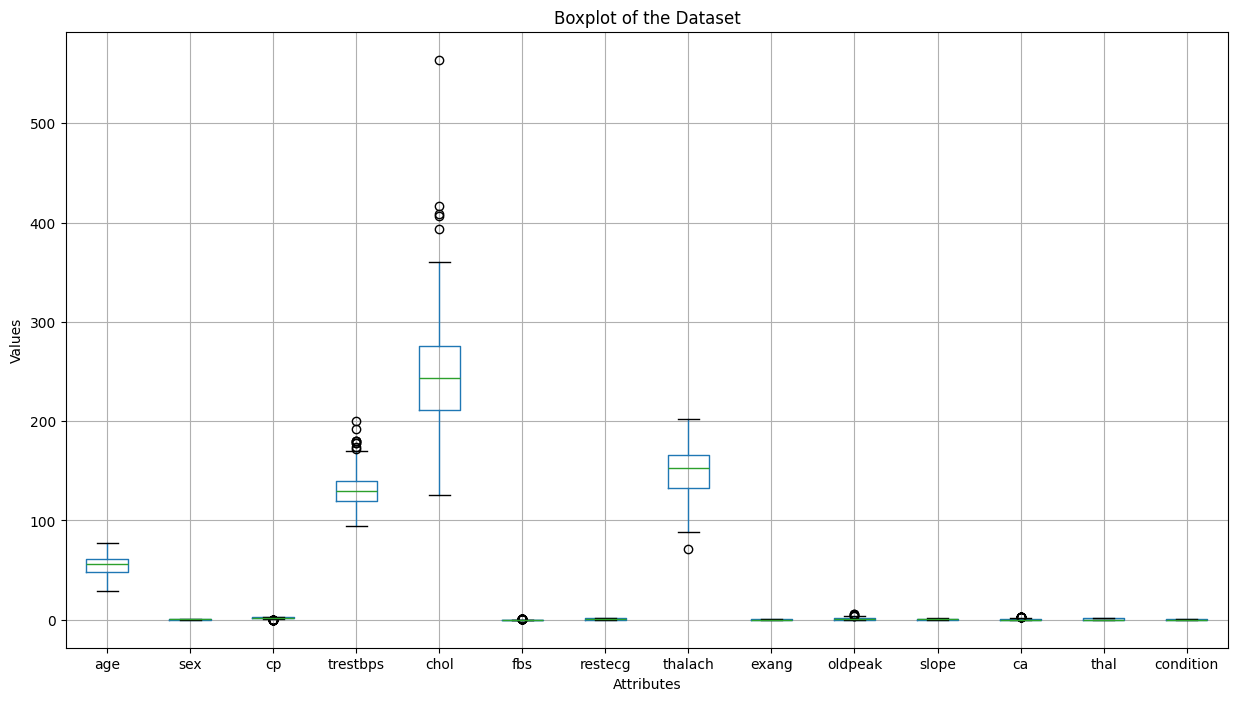

In [7]:
plt.figure(figsize=(15,8))
data.boxplot()
plt.title('Boxplot of the Dataset')
plt.xlabel('Attributes')
plt.ylabel('Values')

In [8]:
num_feats = ['age', 'chol', 'trestbps', 'thalach', 'oldpeak', 'ca']
cat_feats = ['sex', 'fbs', 'exang', 'cp', 'restecg', 'slope', 'thal']
target_col = 'condition'

In [9]:
data[num_feats].describe().T

count        mean        std    min    25%    50%    75%    max
age       297.0   54.542088   9.049736   29.0   48.0   56.0   61.0   77.0
chol      297.0  247.350168  51.997583  126.0  211.0  243.0  276.0  564.0
trestbps  297.0  131.693603  17.762806   94.0  120.0  130.0  140.0  200.0
thalach   297.0  149.599327  22.941562   71.0  133.0  153.0  166.0  202.0
oldpeak   297.0    1.055556   1.166123    0.0    0.0    0.8    1.6    6.2
ca        297.0    0.676768   0.938965    0.0    0.0    0.0    1.0    3.0

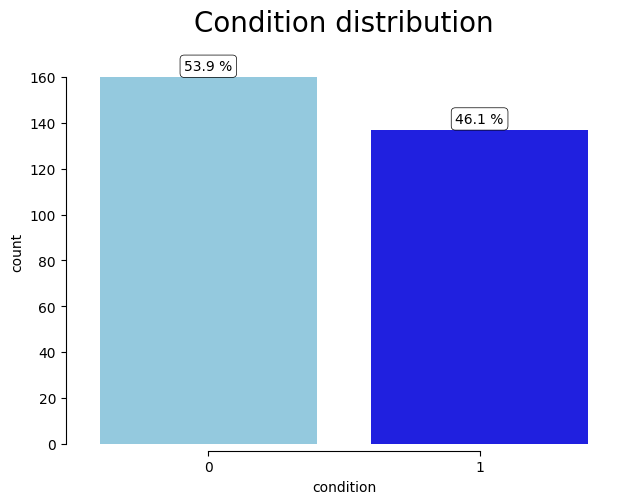

In [10]:
mypal2 = ['#ADD8E6', '#87CEEB', '#4682B4', '#1E90FF', '#0000FF', '#FF6347']
plt.figure(figsize=(7, 5), facecolor='white')
total = float(len(data))


ax = sns.countplot(x=data['condition'], palette=mypal2[1::3])
ax.set_facecolor('white')


for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 3, '{:1.1f} %'.format((height / total) * 100), ha="center",
            bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))


ax.set_title('Condition distribution', fontsize=20, y=1.05)
sns.despine(right=True)
sns.despine(offset=5, trim=True)

plt.show()

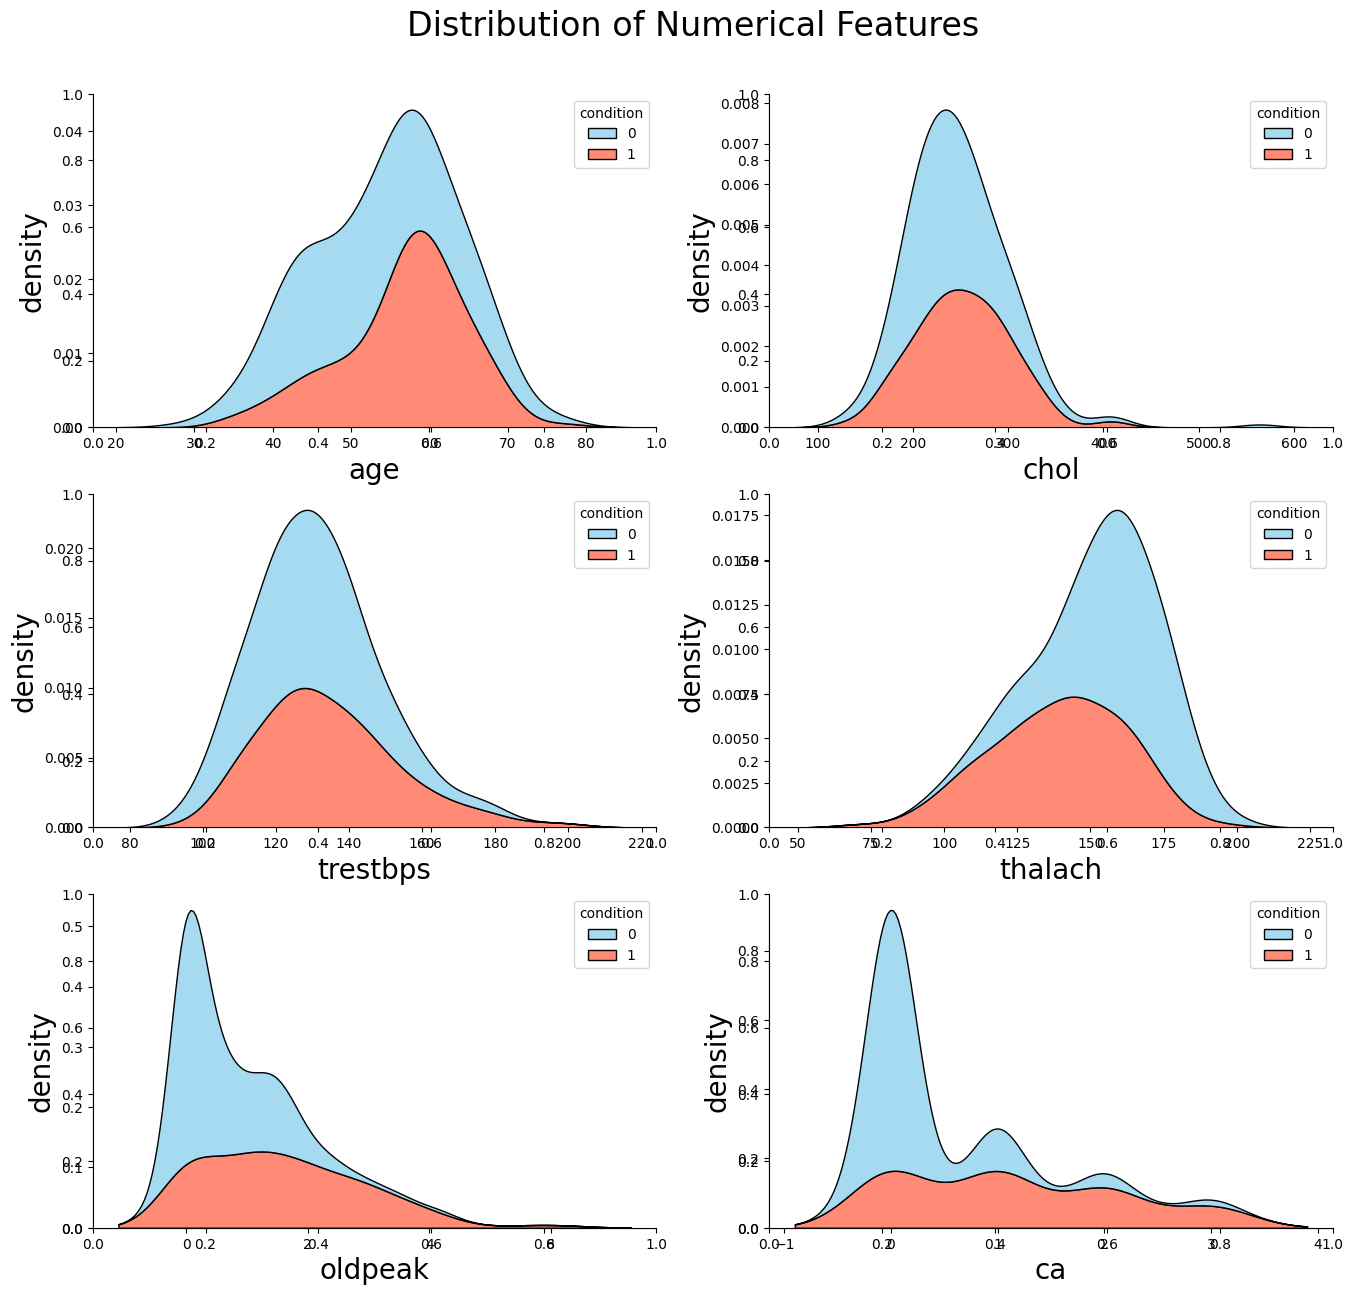

In [12]:
L = len(num_feats)
ncol= 2
nrow= int(np.ceil(L/ncol))


fig, ax = plt.subplots(nrow, ncol, figsize=(16, 14),facecolor='white')
fig.subplots_adjust(top=0.92)

i = 1
for col in num_feats:
    plt.subplot(nrow, ncol, i, facecolor='white')

    ax = sns.kdeplot(data=data, x=col, hue="condition", multiple="stack", palette=mypal2[1::4])
    ax.set_xlabel(col, fontsize=20)
    ax.set_ylabel("density", fontsize=20)
    sns.despine(right=True)
    sns.despine(offset=0, trim=False)

    if col == 'num_major_vessels':
        sns.countplot(data=data, x=col, hue="condition", palette=mypal2[1::4])
        for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.0f}'.format((height)),ha="center",
                      bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

    i = i +1
plt.suptitle('Distribution of Numerical Features' ,fontsize = 24);

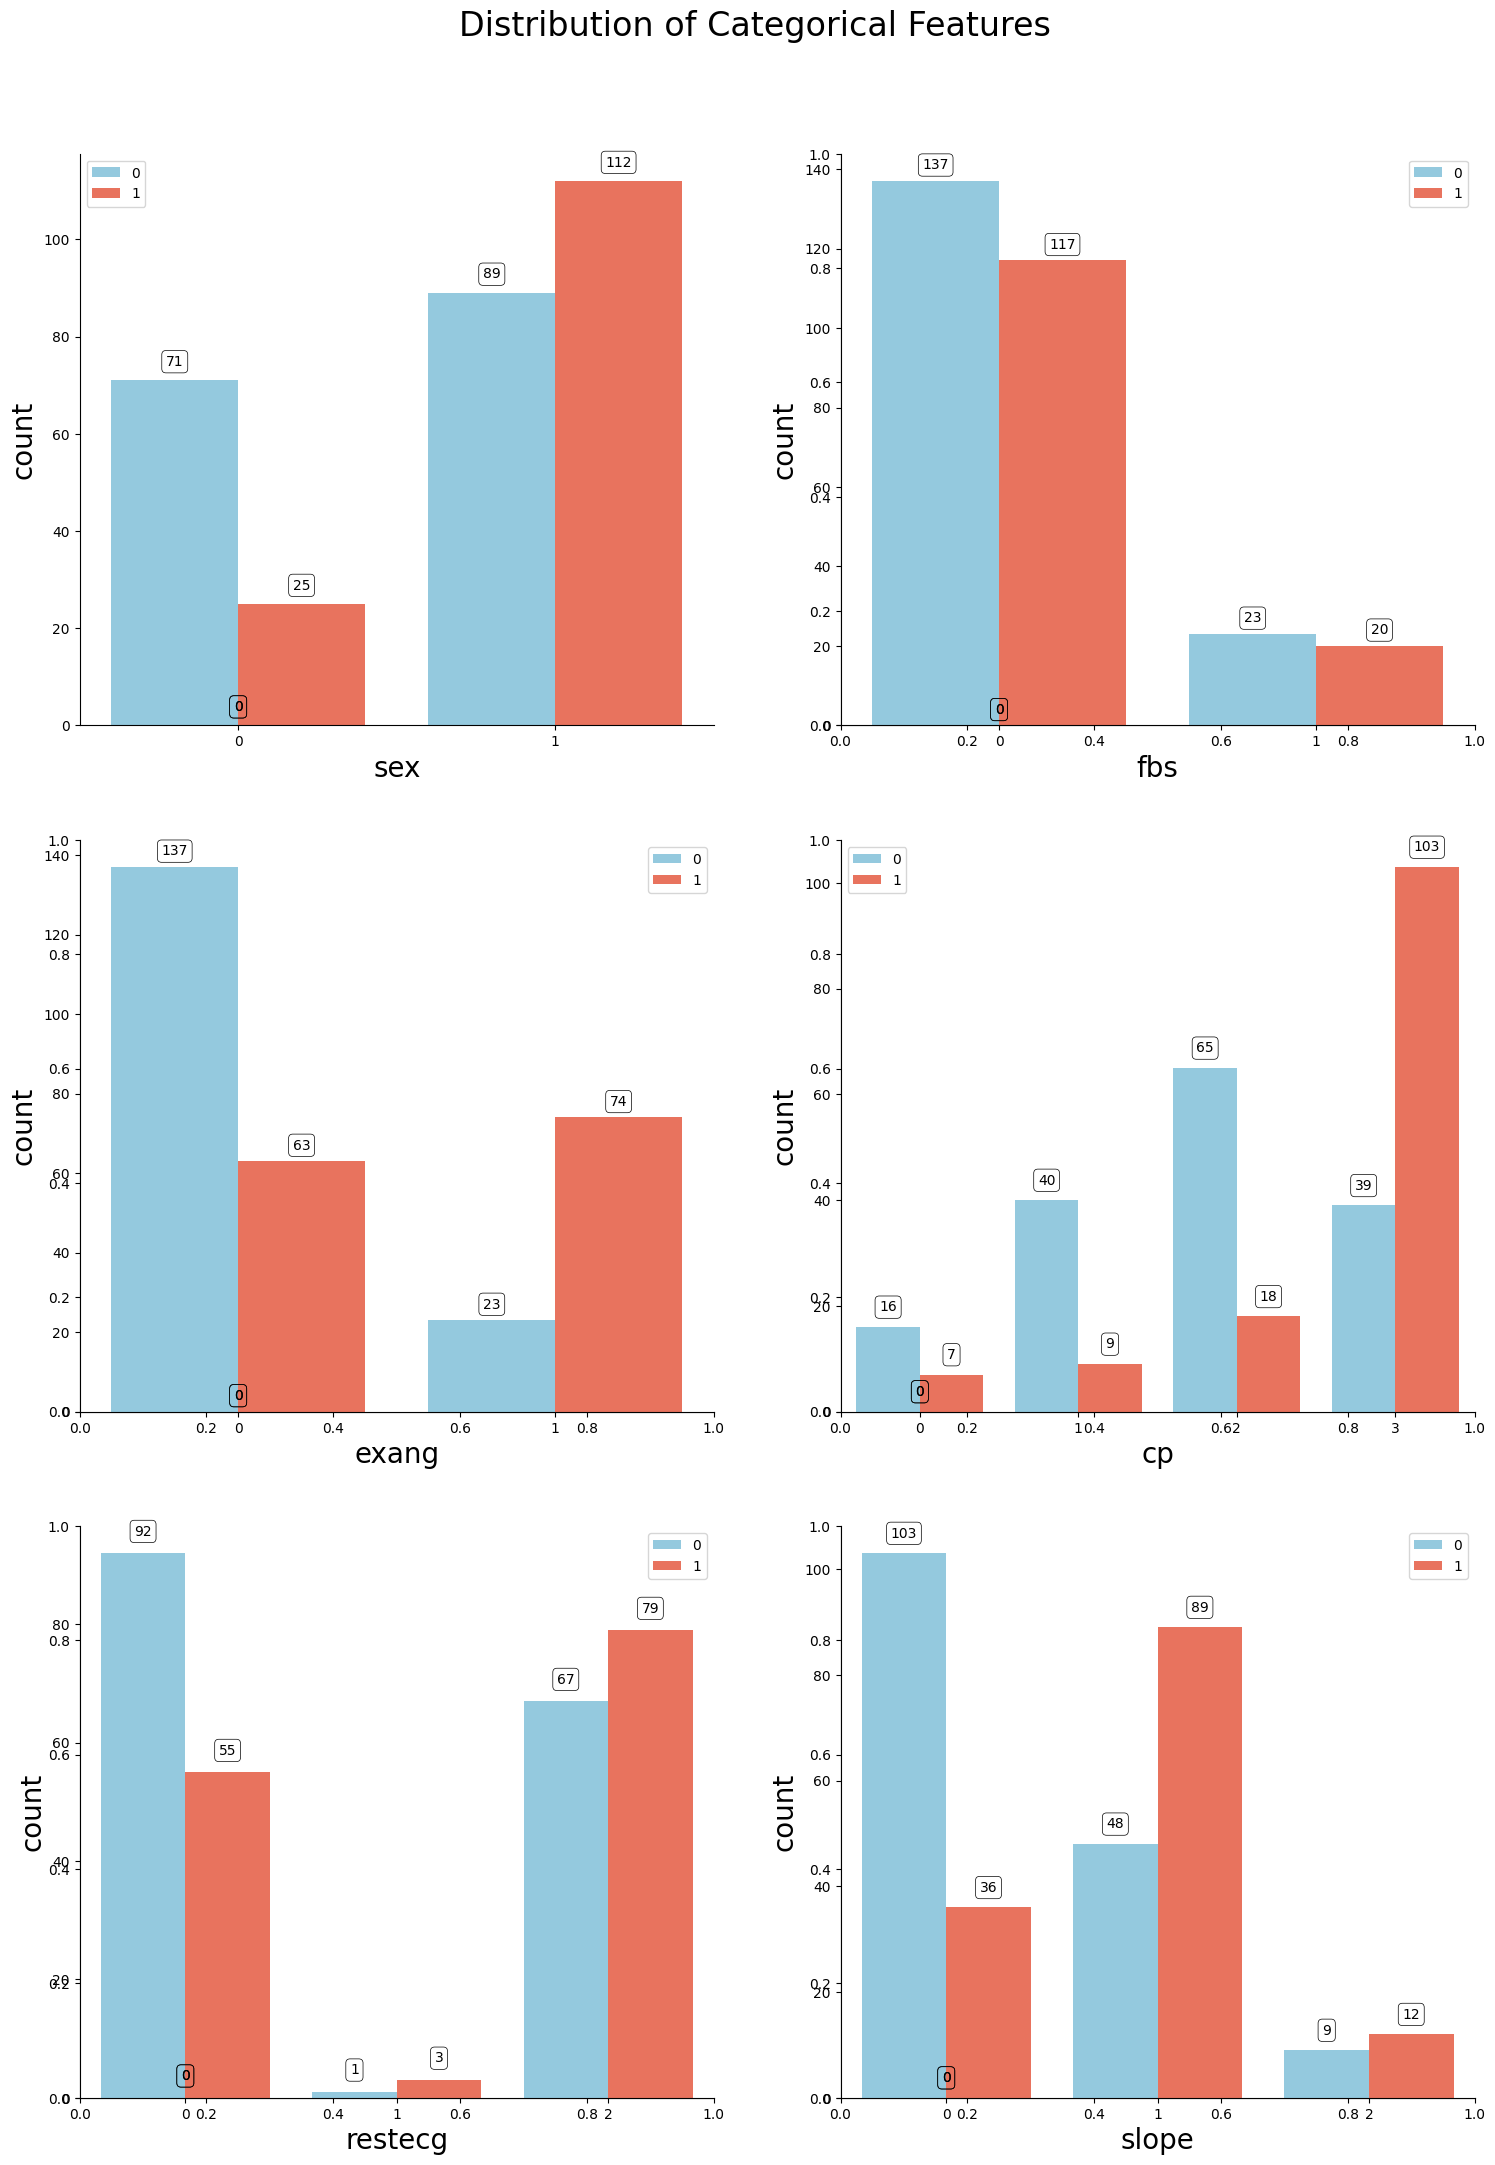

In [13]:
def count_plot(data, cat_feats):
    L = len(cat_feats)
    ncol= 2
    nrow= int(np.ceil(L/ncol))
    remove_last= (nrow * ncol) - L

    fig, ax = plt.subplots(nrow, ncol,figsize=(18, 24), facecolor='white')
    fig.subplots_adjust(top=0.92)
    ax.flat[-remove_last].set_visible(False)

    i = 1
    for col in cat_feats:
        plt.subplot(nrow, ncol, i, facecolor='white')
        ax = sns.countplot(data=data, x=col, hue="condition", palette=mypal2[1::4])
        ax.set_xlabel(col, fontsize=20)
        ax.set_ylabel("count", fontsize=20)
        sns.despine(right=True)
        sns.despine(offset=0, trim=False)
        plt.legend(facecolor='white')

        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x()+p.get_width()/2.,height + 3,'{:1.0f}'.format((height)),ha="center",
                  bbox=dict(facecolor='none', edgecolor='black', boxstyle='round', linewidth=0.5))

        i = i +1

    plt.suptitle('Distribution of Categorical Features' ,fontsize = 24)
    return 0

count_plot(data, cat_feats[0:-1]);

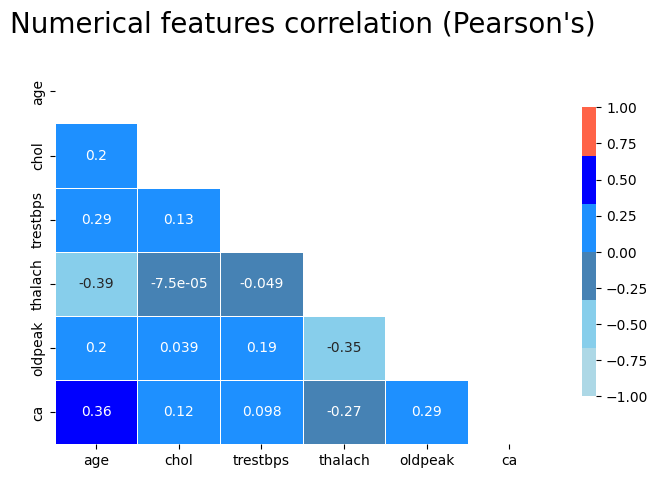

In [14]:
df_ = data[num_feats]
corr = df_.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(mypal2, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Numerical features correlation (Pearson's)", fontsize=20, y= 1.05);

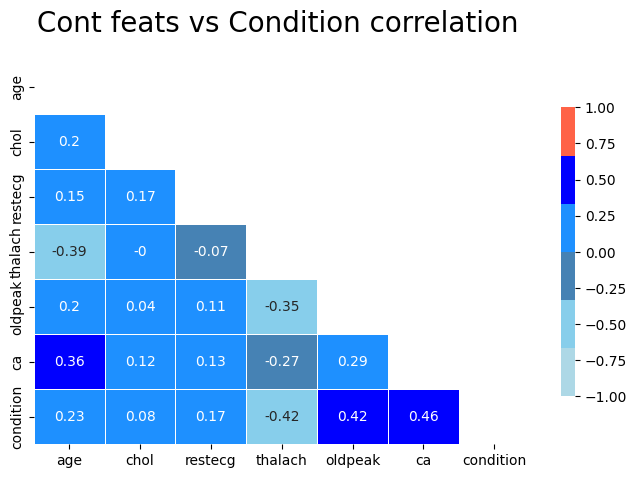

In [15]:
feats_ = ['age', 'chol', 'restecg', 'thalach', 'oldpeak', 'ca', 'condition']

def point_biserial(x, y):
    pb = stats.pointbiserialr(x, y)
    return pb[0]

rows= []
for x in feats_:
    col = []
    for y in feats_ :
        pbs =point_biserial(data[x], data[y])
        col.append(round(pbs,2))
    rows.append(col)

pbs_results = np.array(rows)
DF = pd.DataFrame(pbs_results, columns = data[feats_].columns, index =data[feats_].columns)

mask = np.triu(np.ones_like(DF, dtype=bool))
corr = DF.mask(mask)

f, ax = plt.subplots(figsize=(8, 5), facecolor=None)
cmap = sns.color_palette(mypal2, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1, center=0, annot=True,
            square=False, linewidths=.5, cbar_kws={"shrink": 0.75})
ax.set_title("Cont feats vs Condition correlation ", fontsize=20, y= 1.05);

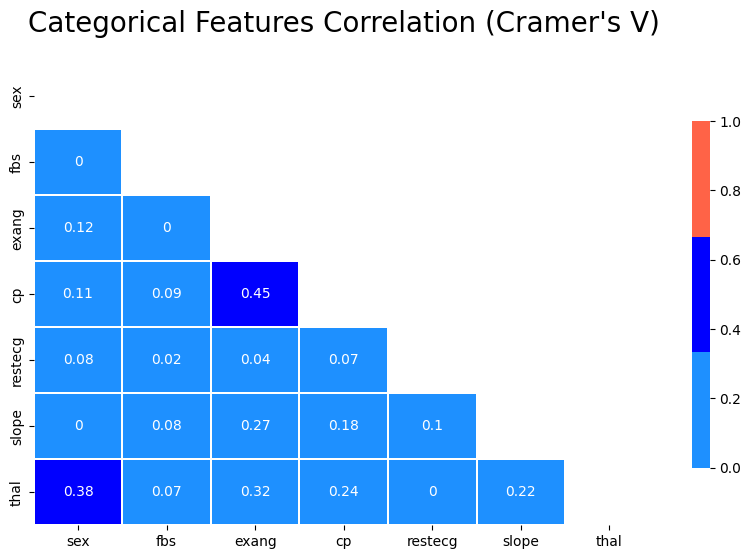

In [16]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))


data_ = data[cat_feats]
rows= []
for x in data_:
    col = []
    for y in data_ :
        cramers =cramers_v(data_[x], data_[y])
        col.append(round(cramers,2))
    rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_.columns, index = data_.columns)


mypal2 = ['#ADD8E6', '#87CEEB', '#4682B4', '#1E90FF', '#0000FF', '#FF6347']

mask = np.triu(np.ones_like(df, dtype=bool))
corr = df.mask(mask)
f, ax = plt.subplots(figsize=(10, 6), facecolor=None)
cmap = sns.color_palette(mypal2, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=0, center=0, annot=True,
            square=False, linewidths=.01, cbar_kws={"shrink": 0.75})
ax.set_title("Categorical Features Correlation (Cramer's V)", fontsize=20, y= 1.05);

In [20]:
def handle_outliers_iqr(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df


for col in num_feats:
    data = handle_outliers_iqr(data, col)

In [21]:
# =============================================================================
# 3. Model Training and Comparison
# =============================================================================


y = data[target_col]
X = data.drop(target_col, axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=45, stratify=y)

In [22]:
print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)

Train set size: (207, 13)
Test set size: (90, 13)


In [23]:
cat_model = CatBoostClassifier(random_state=45, verbose=0).fit(X_train, y_train)
lgb_model = LGBMClassifier(random_state=45, verbose=-1).fit(X_train, y_train)
xgb_model = XGBClassifier(objective='binary:logistic', random_state=45).fit(X_train, y_train)

In [25]:
names = ["CatBoost", "LightGBM", "XGBoost"]
classifiers = [cat_model, lgb_model, xgb_model]


from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score, f1_score
def score_summary(names, classifiers, X_test, y_test):
    scores = []
    for name, model in zip(names, classifiers):
        preds = model.predict(X_test)
        preds_proba = model.predict_proba(X_test)[:,1]
        scores.append({
            "Model": name,
            "Accuracy": accuracy_score(y_test, preds),
            "ROC_AUC": roc_auc_score(y_test, preds_proba),
            "Recall": recall_score(y_test, preds),
            "Precision": precision_score(y_test, preds),
            "F1": f1_score(y_test, preds)
        })
    return pd.DataFrame(scores).set_index("Model")


summary_df = score_summary(names, classifiers, X_test, y_test)

styled = summary_df.sort_values(by='Accuracy', ascending=False)\
.style.background_gradient(cmap='coolwarm')\
.bar(subset=["ROC_AUC"], color='#6495ED')\
.bar(subset=["Recall"], color='#ff355d')\
.bar(subset=["Precision"], color='lightseagreen')\
.bar(subset=["F1"], color='gold')

styled

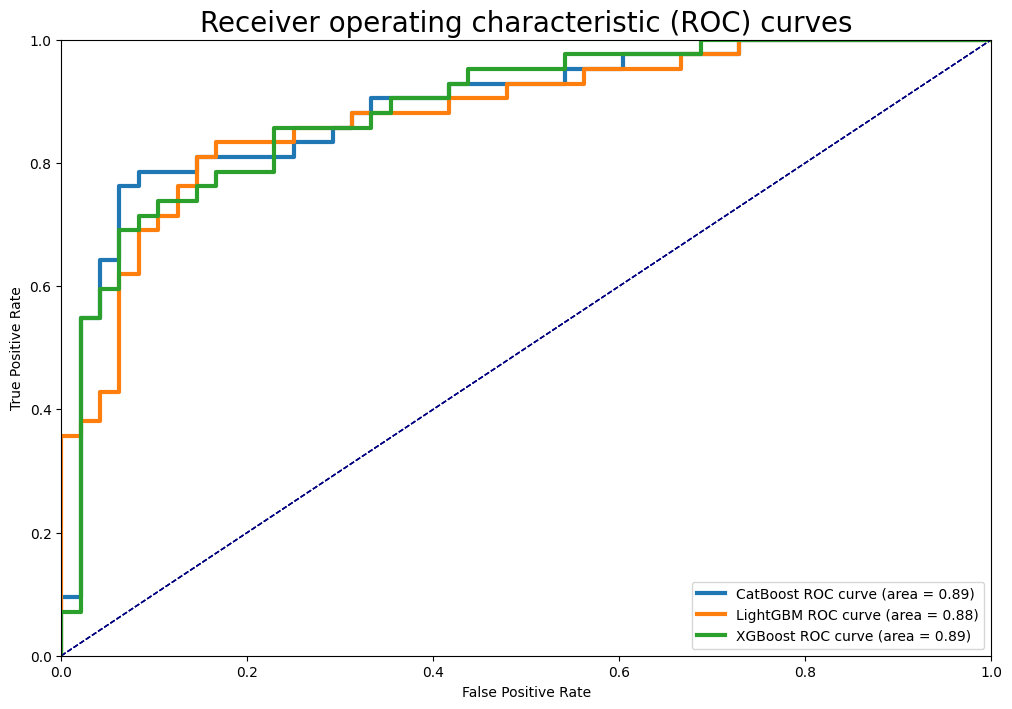

In [26]:
def roc_auc_curve(names, classifiers):

    plt.figure(figsize=(12, 8))

    for name, clf in zip(names, classifiers):

        pred_proba = clf.predict_proba(X_test)[:, 1]

        fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, lw=3, label= name +' ROC curve (area = %0.2f)' % (roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic (ROC) curves', fontsize=20)
        plt.legend(loc="lower right")



roc_auc_curve(names, classifiers)

In [27]:
# =============================================================================
# 4. Cross-Validation
# =============================================================================


cv_model = CatBoostClassifier(random_state=45, verbose=0)

cv_results = cross_validate(cv_model, X_train, y_train, cv=5, scoring=["accuracy", "f1", "roc_auc"])
print("CV Accuracy :", cv_results['test_accuracy'].mean())
print("CV F1 :", cv_results['test_f1'].mean())
print("CV ROC AUC :", cv_results['test_roc_auc'].mean())

CV Accuracy : 0.8255516840882693
CV F1 : 0.79997191997192
CV ROC AUC : 0.9042438111087996


In [29]:
# =============================================================================
# 5. Hyperparameter Optimization
# =============================================================================


param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'iterations': [100, 200]
}

cv_model = CatBoostClassifier(random_state=42, verbose=0)

grid_search = GridSearchCV(cv_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters :", grid_search.best_params_)
print("Best CV score :", grid_search.best_score_)

Best parameters : {'depth': 8, 'iterations': 200, 'learning_rate': 0.1}
Best CV score : 0.8350754936120788


In [30]:
best_params = grid_search.best_params_

final_model = CatBoostClassifier(**best_params, random_state=42, verbose=0)
final_model.fit(X_train, y_train)


y_pred_final = final_model.predict(X_test)
y_pred_proba_final = final_model.predict_proba(X_test)[:, 1]

print("\nFinal Model Performance Report (Independent Test Data):")
print("-" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_final):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_final):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_final):.4f}")
print(f"F1: {f1_score(y_test, y_pred_final):.4f}")


train_preds_final = final_model.predict(X_train)
train_accuracy_final = accuracy_score(y_train, train_preds_final)

print(f"Training Data Accuracy: {train_accuracy_final:.4f}")
print(f"Test Data Accuracy: {accuracy_score(y_test, y_pred_final):.4f}")




Final Model Performance Report (Independent Test Data):
--------------------------------------------------
Accuracy: 0.8222
ROC AUC: 0.8681
Recall: 0.8095
Precision: 0.8095
F1: 0.8095
Training Data Accuracy: 1.0000
Test Data Accuracy: 0.8222


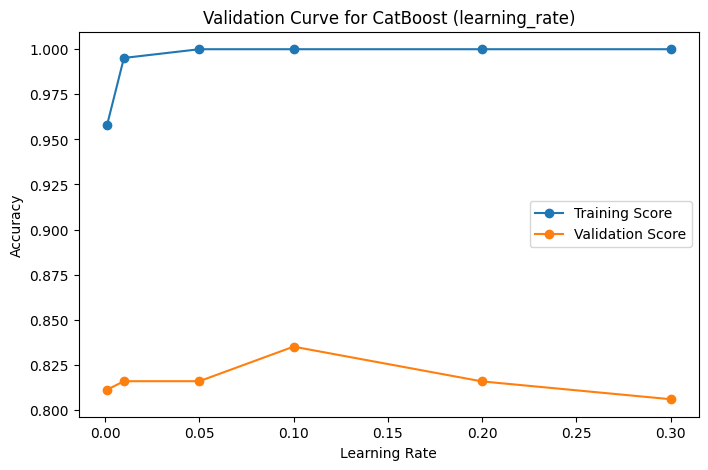

In [32]:
depth = 8
iterations = 200


param_range = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]

train_scores, test_scores = validation_curve(
    CatBoostClassifier(depth=depth, iterations=iterations, verbose=0, random_state=42),
    X_train,
    y_train,
    param_name="learning_rate",
    param_range=param_range,
    scoring="accuracy",
    cv=5
)


train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)


plt.figure(figsize=(8, 5))
plt.plot(param_range, train_mean, label="Training Score", marker='o')
plt.plot(param_range, test_mean, label="Validation Score", marker='o')
plt.title("Validation Curve for CatBoost (learning_rate)")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid(False)
plt.show()

In [38]:
# =============================================================================
# 6. Permutation Importance
# =============================================================================


perm = PermutationImportance(final_model, random_state=45).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist())

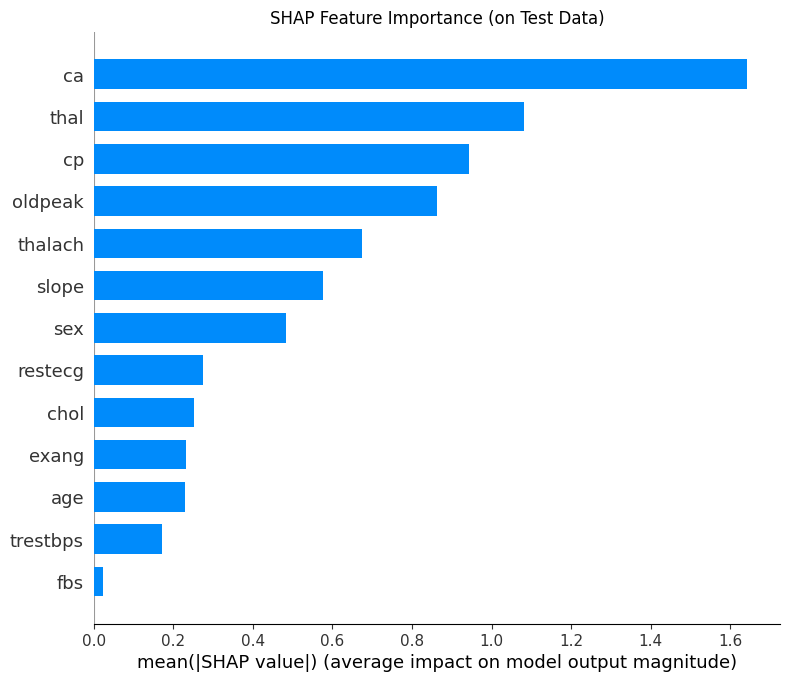

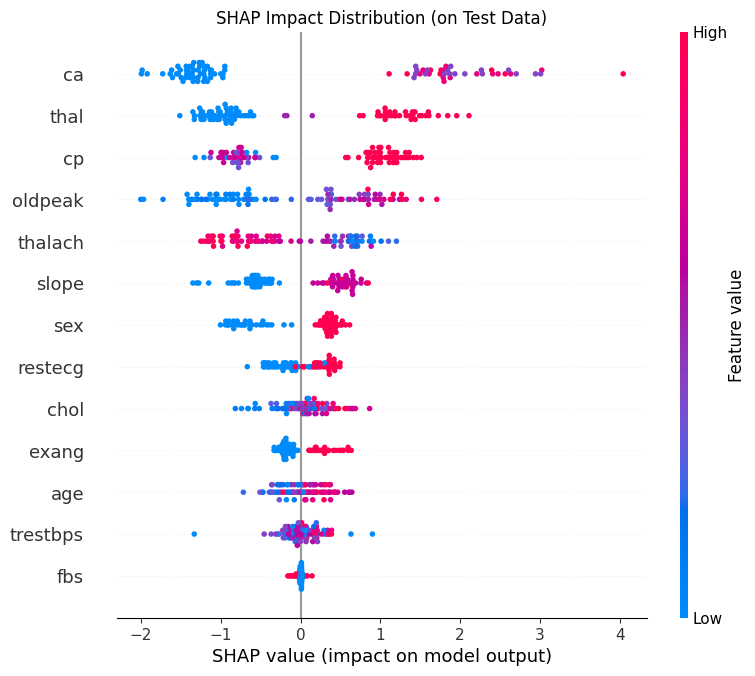

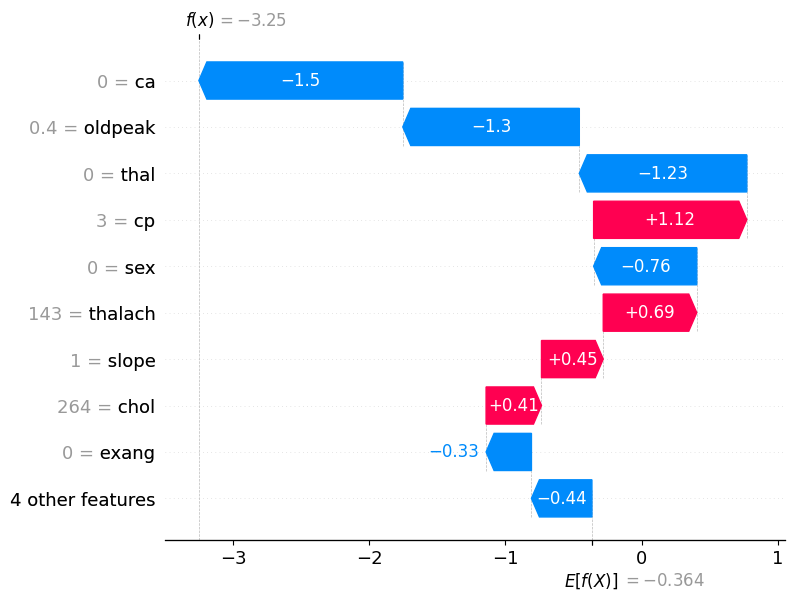

In [33]:
# =============================================================================
# 7. SHAP
# =============================================================================


explainer = shap.Explainer(final_model)

shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (on Test Data)")
plt.show()

shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Impact Distribution (on Test Data)")
plt.show()


shap.plots.waterfall(shap_values[0])

In [35]:
# =============================================================================
# 8. LIME
# =============================================================================


explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=["No Disease", "Disease"],
    mode='classification'
)

exp = explainer.explain_instance(X.iloc[0].values, final_model.predict_proba, num_features=10)

exp.show_in_notebook(show_table=True)

In [37]:
try:
    matching_index_in_test_set = X_test[
        (X_test['ca'] == 0) &
        (X_test['oldpeak'] == 0.4) &
        (X_test['sex'] == 0) &
        (X_test['cp'] == 3)
    ].index[0]


    instance_to_explain = X_test.loc[matching_index_in_test_set]
    print(f"Example from SHAP plot found. Index in test set: {matching_index_in_test_set}")

except IndexError:
    print("No example found with the specified features. Examining the first test example.")
    instance_to_explain = X_test.iloc[0]


print("\nFeatures of the example being examined:")
print(instance_to_explain)


exp = explainer.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=final_model.predict_proba,
    num_features=10
)


exp.show_in_notebook(show_table=True)

Example from SHAP plot found. Index in test set: 251

Features of the example being examined:
age          53.0
sex           0.0
cp            3.0
trestbps    130.0
chol        264.0
fbs           0.0
restecg       2.0
thalach     143.0
exang         0.0
oldpeak       0.4
slope         1.0
ca            0.0
thal          0.0
Name: 251, dtype: float64
